In [371]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Here, we start preprocessing the Pulsar dataset. Throughout this notebook, we'll apply power transformation to reduce skewness, standardize the features, and then apply PCA to address multicollinearity issues. First, we start by loading the dataset and renaming the columns for clarity.

In [372]:
df = pd.read_csv('../data/raw/pulsar.csv')

In [373]:
# Rename columns
df.columns = [
    'mean_integrated_profile',
    'std_integrated_profile',
    'kurtosis_integrated_profile',
    'skewness_integrated_profile',
    'mean_dm_snr_curve',
    'std_dm_snr_curve',
    'kurtosis_dm_snr_curve',
    'skewness_dm_snr_curve',
    'target_class'
]

In [374]:
X = df.drop('target_class', axis=1)
y = df['target_class']

As noted in notebook 1.0.0, the features exhibit significant skewness, outliers and multicollinearity.
- Each of them present a different distribution, therefore a group-wise transformation is more appropriate.
- Also, we have negative values, so we cannot use a simple logarithmic transformation. Instead, we will use the Yeo-Johnson power transformation, which can handle zero and negative values.
- To address outliers, we will apply winsorization after the power transformation.
- Then, we standardize the features to have zero mean and unit variance. This is also important for PCA, which is sensitive to the scale of the features.

In [375]:
def winsorize_df(X, lower=0.01, upper=0.99):
    q_low = X.quantile(lower)
    q_high = X.quantile(upper)
    return X.clip(lower=q_low, upper=q_high, axis=1)

winsor = FunctionTransformer(
    lambda X: winsorize_df(pd.DataFrame(X), lower=0.01, upper=0.99).to_numpy(),
    feature_names_out="one-to-one",
)

In [376]:
pipe = make_pipeline(
    PowerTransformer(method='yeo-johnson', standardize=False),
    winsor,
    StandardScaler()
)

In [377]:
dfs = []
for c, g in df.groupby('target_class'):
    Xt = pipe.fit_transform(g.drop('target_class', axis=1))
    g_tr = pd.DataFrame(Xt, columns=g.drop(columns=["target_class"]).columns, index=g.index)
    g_tr['target_class'] = c
    dfs.append(g_tr)
df_processed = pd.concat(dfs).sort_index()

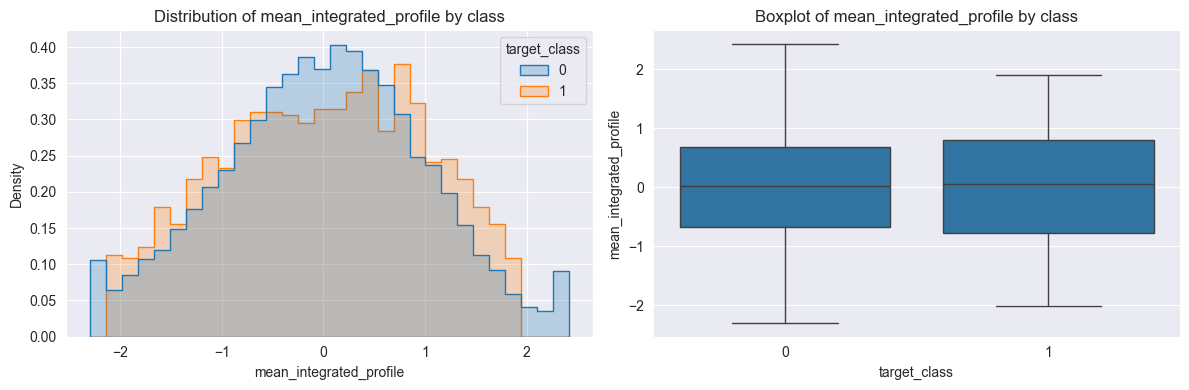

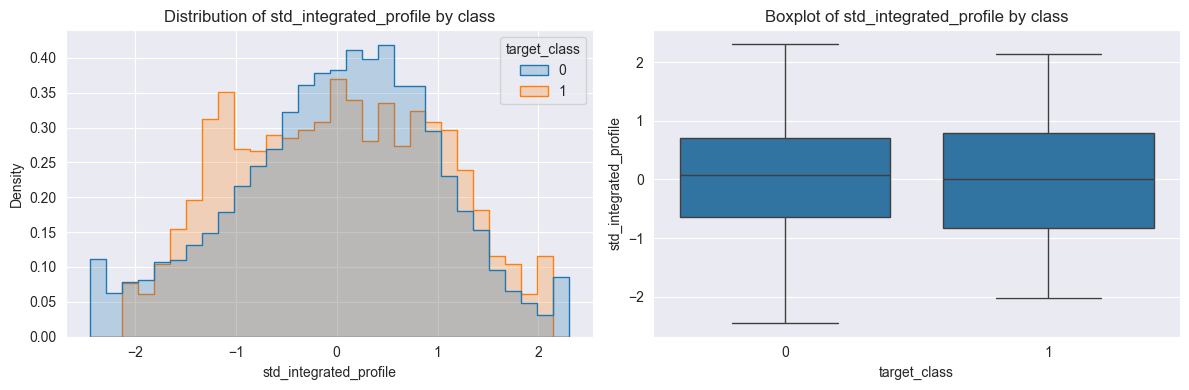

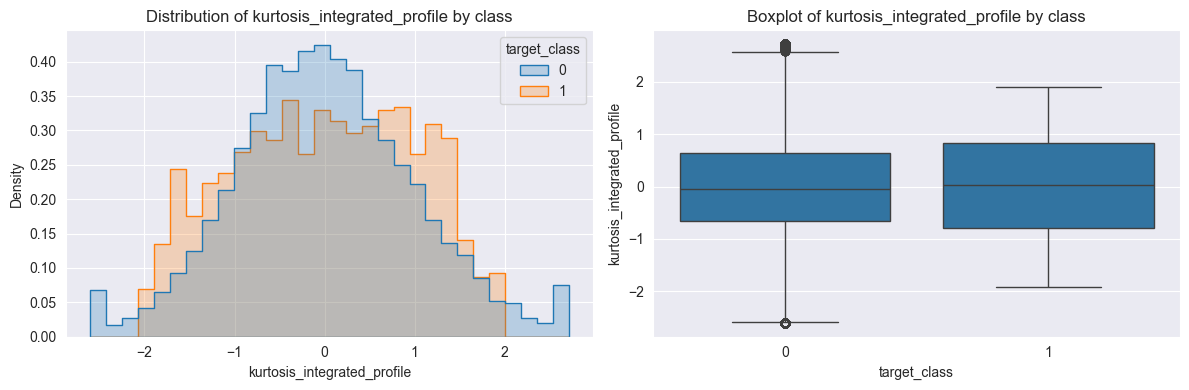

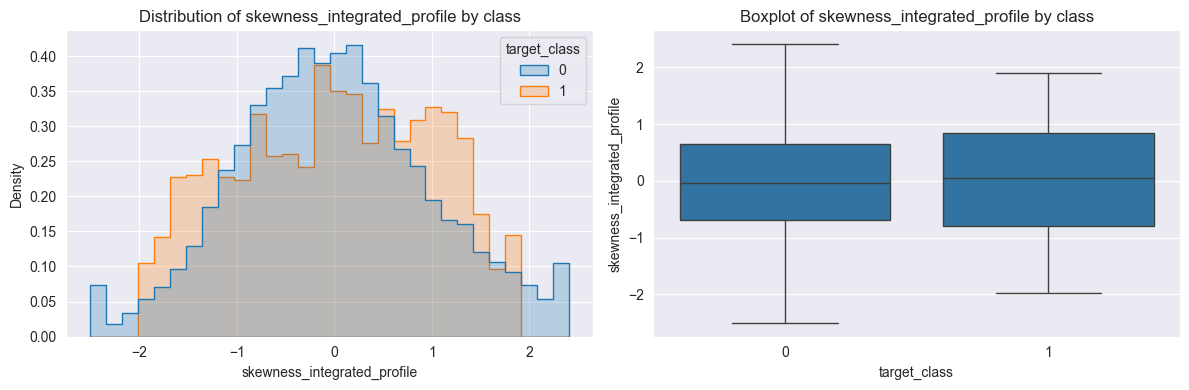

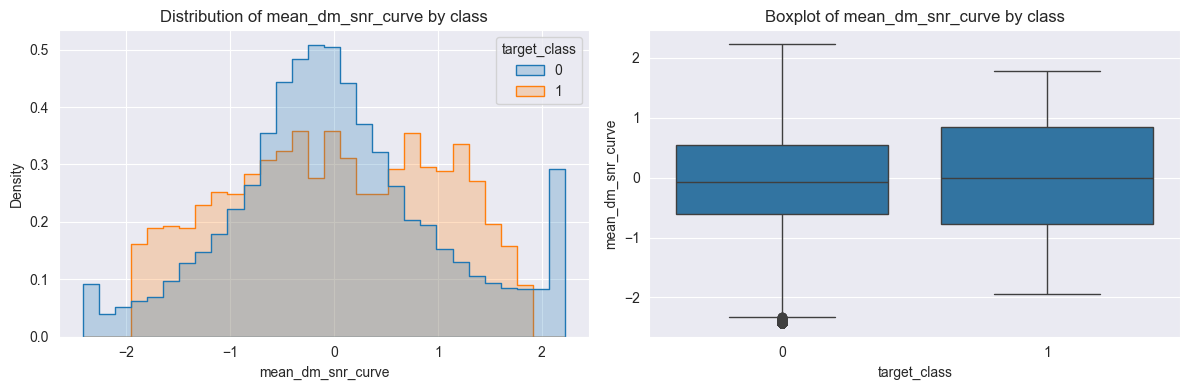

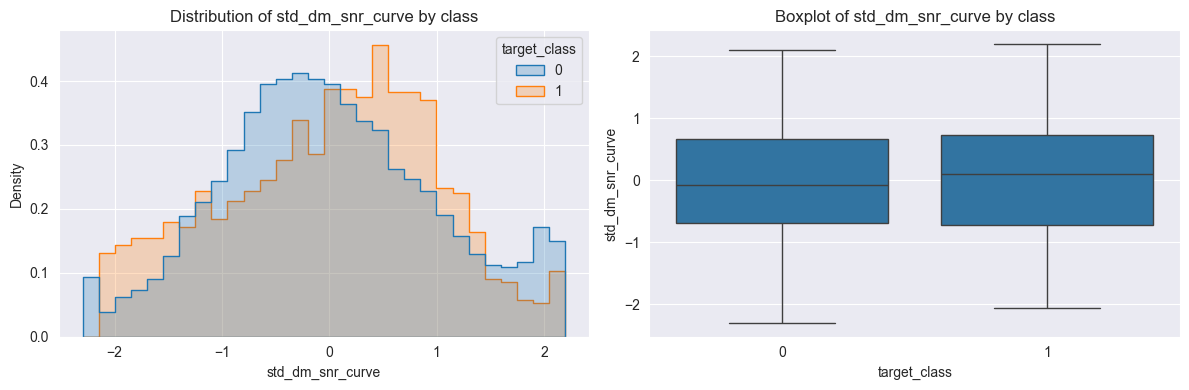

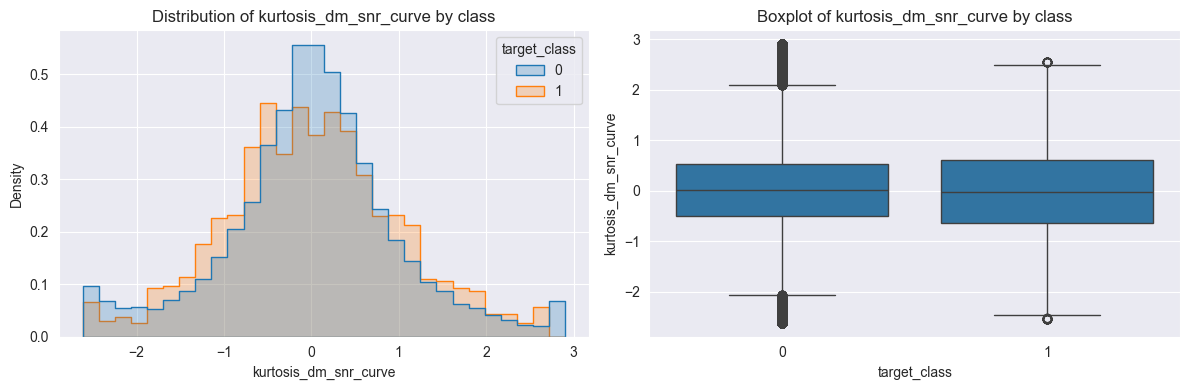

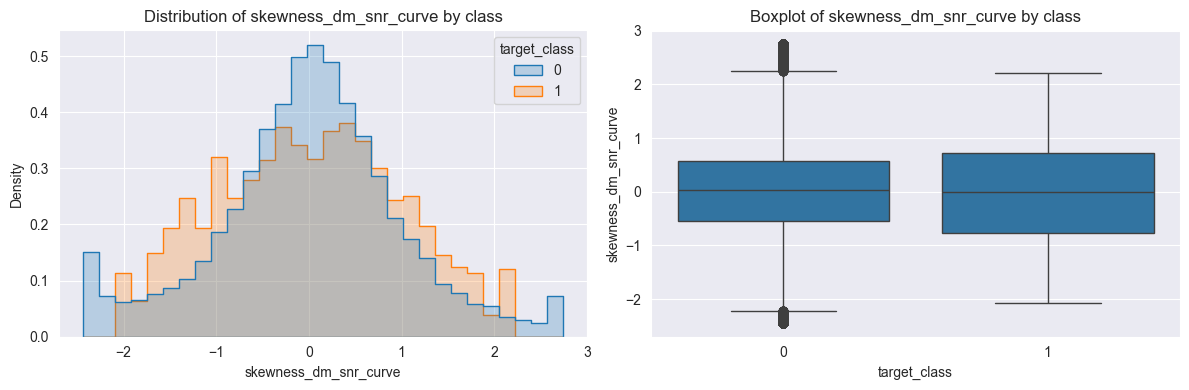

In [378]:
feature_columns = [col for col in df_processed.columns if col != 'target_class']

for feature in feature_columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(
        data=df_processed,
        x=feature,
        hue='target_class',
        stat='density',
        common_norm=False,
        element='step',
        bins=30,
        ax=axes[0],
    )
    axes[0].set_title(f"Distribution of {feature} by class")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("Density")

    sns.boxplot(data=df_processed, x='target_class', y=feature, ax=axes[1])
    axes[1].set_title(f"Boxplot of {feature} by class")
    axes[1].set_xlabel('target_class')
    axes[1].set_ylabel(feature)

    plt.tight_layout()
    plt.show()

In [379]:
outlier_counts = {}
for col in df_processed.columns:
    q1 = df_processed[col].quantile(0.25)
    q3 = df_processed[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df_processed[(df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)]
    outlier_counts[col] = outliers.shape[0]

In [380]:
outlier_counts

{'mean_integrated_profile': 0,
 'std_integrated_profile': 0,
 'kurtosis_integrated_profile': 185,
 'skewness_integrated_profile': 0,
 'mean_dm_snr_curve': 168,
 'std_dm_snr_curve': 0,
 'kurtosis_dm_snr_curve': 1140,
 'skewness_dm_snr_curve': 726,
 'target_class': 1639}

Then, we apply PCA to reduce multicollinearity and potentially reduce the number of features while retaining most of the variance in the data. In this case, we will retain 95% of the variance. For that value, PCA reduces the number of features from 8 to 5.

In [381]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [382]:
print(f'Original number of features: {X.shape[1]}')
print(f'Number of features after PCA: {X_pca.shape[1]}')

Original number of features: 8
Number of features after PCA: 5


In [383]:
# Reconstruct the DataFrame from PCA components
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['target_class'] = y.values

In [384]:
# Export the processed dataset
df_pca.to_csv('../data/processed/pulsar_processed.csv', index=False)